# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from imblearn import under_sampling as us
from imblearn import over_sampling  as osamp
from imblearn import combine        as comb

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
100130,d9w7hmnrq3,2013-08-17,20130817165618,2015-06-29,-unknown-,49.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
32529,9qpfq8nf04,2012-07-18,2012-07-18 07:22:19,2012-07-19,FEMALE,33,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 57% for the NDF class and 30% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [22]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [23]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [24]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [25]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

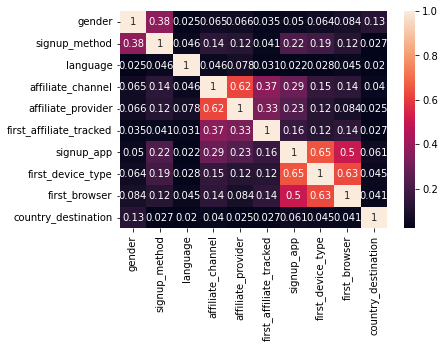

In [26]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [27]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

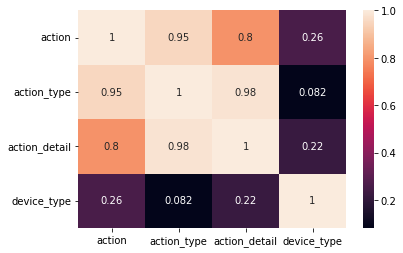

In [28]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

In [29]:
df02_users = df01_users.copy()

In [30]:
df02_users.shape

(207386, 16)

## 2.1. Create Gap Between Dates Features

In [31]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [32]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [33]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [34]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

In [35]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [36]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 120)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [37]:
# columns used to feature enginnering
cols_date =['timestamp_first_active',
            'date_first_active',
            'date_account_created',
            'date_first_booking']

df03_users = df03_users.drop(columns=cols_date)

# 4.0. Data Exploratory Analysis

To increase time, the EDA stage will be skipped in this first cycle.

In [38]:
df04_users = df03_users.copy()

df04_users.shape

(206593, 31)

# 5.0. Data Preparation

In [39]:
df05_users = df04_users.copy()

## 5.1. Balanced Dataset

### 5.1.1. Encode Categorical Features 

In [40]:
# Enconder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
cols_num = df05_users.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
cols_cat = df05_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# Datetime - not used
cols_date = df05_users.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Encoding
df05_users_dummy =  pd.DataFrame(ohe.fit_transform(df05_users[cols_cat]).toarray(), index=df05_users.index)

# Join numerical and categorical
df05_users_encoder = pd.concat([df05_users[cols_num], df05_users_dummy], axis=1)

### 5.1.2. Random Undersampling

In [41]:
# define sampler - random under-sampling
undersampling = us.RandomUnderSampler(sampling_strategy='not minority', random_state=32)

# resample the dataset
X_under, y_under = undersampling.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [42]:
df05_users['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [43]:
y_under.value_counts()

CA       213
US       213
DE       213
other    213
IT       213
ES       213
FR       213
NL       213
PT       213
AU       213
GB       213
NDF      213
Name: country_destination, dtype: int64

In [44]:
# Convert Back to Original Representation
# Numerical
X_under_num = X_under[cols_num]

# inverse transform categorical dataset 
X_under_cat = pd.DataFrame(
    ohe.inverse_transform(X_under.drop(columns=cols_num)), columns=cols_cat, index=X_under.index
)

# join data - without id and datetime features
df05_users_under = pd.concat([X_under_num, X_under_cat], axis=1)

df05_users_under['country_destination'] = y_under

In [45]:
# dummy variable
df05_users_under_dummy = pd.get_dummies(df05_users_under.drop(['country_destination'], axis=1))

# join id and country destination
df05_users_under = pd.concat( [df05_users_under['country_destination'], df05_users_under_dummy], axis=1 )

### 5.1.3. Random Oversampling

In [46]:
# define sampler - random over-sampling
oversampling = osamp.RandomOverSampler(sampling_strategy='not majority', random_state=32)

# resample the dataset
X_over, y_over = oversampling.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [47]:
df05_users['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [48]:
y_over.value_counts()

CA       119810
US       119810
IT       119810
PT       119810
GB       119810
FR       119810
AU       119810
NDF      119810
NL       119810
other    119810
DE       119810
ES       119810
Name: country_destination, dtype: int64

In [49]:
# Convert Back to Original Representation
# Numerical
X_over_num = X_over[cols_num]

# inverse transform categorical dataset 
X_over_cat = pd.DataFrame(
    ohe.inverse_transform(X_over.drop(columns=cols_num)), columns=cols_cat, index=X_over.index
)

# join data - without id and datetime features
df05_users_over = pd.concat([X_over_num, X_over_cat], axis=1)

df05_users_over['country_destination'] = y_over

In [50]:
# dummy variable
df05_users_over_dummy = pd.get_dummies(df05_users_over.drop(['country_destination'], axis=1))

# join id and country destination
df05_users_over = pd.concat( [df05_users_over['country_destination'], df05_users_over_dummy], axis=1 )

### 5.1.4. SMOTE + TOMEKLINK

In [51]:
# define sampler - over-sampling using SMOTE and cleaning using Tomek links
combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# resample the dataset
X_comb, y_comb = combine.fit_resample(df05_users_encoder, df05_users['country_destination'])

In [52]:
df05_users['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [53]:
y_comb.value_counts()

PT       119810
AU       119810
NL       119810
NDF      119809
DE       119809
CA       119800
ES       119799
GB       119789
IT       119782
FR       119743
other    119676
US       119631
Name: country_destination, dtype: int64

In [54]:
# Convert Back to Original Representation
# Numerical
X_comb_num = X_comb[cols_num]

# inverse transform categorical dataset 
X_comb_cat = pd.DataFrame(
    ohe.inverse_transform(X_comb.drop(columns=cols_num)), columns=cols_cat, index=X_comb.index
)

# join data - without id and datetime features
df05_users_comb = pd.concat([X_comb_num, X_comb_cat], axis=1)

df05_users_comb['country_destination'] = y_comb

In [55]:
# dummy variable
df05_users_comb_dummy = pd.get_dummies(df05_users_comb.drop(['country_destination'], axis=1))

# join id and country destination
df05_users_comb = pd.concat( [df05_users_comb['country_destination'], df05_users_comb_dummy], axis=1 )

df05_users_comb.to_csv('../Datasets/data_balanced_smote_tomek.csv')

# 6.0. Feature Selection

In [56]:
df06_users = df05_users.copy()

df06_users_under = df05_users_under
df06_users_over = df05_users_over
df06_users_comb = df05_users_comb

In [57]:
# training dataset
X = df06_users.drop( 'country_destination', axis=1 )
X_under = df06_users_under.drop( 'country_destination', axis=1 )
X_over = df06_users_over.drop( 'country_destination', axis=1 )
X_comb = df06_users_comb.drop( 'country_destination', axis=1 )

#  training response dataset
y = df06_users['country_destination']
y_under = df06_users_under['country_destination']
y_over = df06_users_over['country_destination']
y_comb = df06_users_comb['country_destination']

In [58]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

X_train_under, X_test_under, y_train_under, y_test_under = ms.train_test_split(X_under, y_under, test_size=0.2, random_state=32)

X_train_over, X_test_over, y_train_over, y_test_over = ms.train_test_split(X_over, y_over, test_size=0.2, random_state=32)

X_train_comb, X_test_comb, y_train_comb, y_test_comb = ms.train_test_split(X_comb, y_comb, test_size=0.2, random_state=32)

# 7.0. Machine Learing Model

In [59]:
x_train = X_train
x_test = X_test

x_train_under = X_train_under
x_test_under = X_test_under

x_train_over = X_train_over
x_test_over = X_test_over

x_train_comb = X_train_comb
x_test_comb = X_test_comb

## 7.1. Baseline Model - Random

In [60]:
country_list = df06_users['country_destination'].drop_duplicates().sort_values().tolist()

k_num = y_test.shape[0]

country_weights = df06_users['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

## 7.2. Neural Network - MLP

### 7.2.1. Neural Network - Random Undersampling

In [61]:
ohe_under = pp.OneHotEncoder()

y_train_under_nn = ohe_under.fit_transform(y_train_under.values.reshape(-1, 1)).toarray()

In [62]:
# model definition
model_under = ml.Sequential()
model_under.add( l.Dense(128, input_dim=x_train_under.shape[1], activation='relu') )
model_under.add( l.Dense(12, activation='softmax') )

# model compile
model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_under.fit(x_train_under, y_train_under_nn, epochs=100)

Epoch 1/100
64/64 [==============================] - 0s 2ms/step - loss: 74.6477 - accuracy: 0.1130
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 9.9579 - accuracy: 0.1644
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 8.9437 - accuracy: 0.1693
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 13.9009 - accuracy: 0.1629
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 11.0084 - accuracy: 0.1673
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 10.8249 - accuracy: 0.1737
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 10.5657 - accuracy: 0.1610
Epoch 8/100
64/64 [==============================] - 0s 2ms/step - loss: 10.9944 - accuracy: 0.1649
Epoch 9/100
64/64 [==============================] - 0s 1ms/step - loss: 8.3406 - accuracy: 0.1717
Epoch 10/100
64/64 [==============================] - 0s 2ms/step - loss: 10.4865 - accuracy: 0.1610
Ep

### 7.2.2. Neural Network - Random Oversampling

In [63]:
ohe_over = pp.OneHotEncoder()

y_train_over_nn = ohe_over.fit_transform(y_train_over.values.reshape(-1, 1)).toarray()

In [64]:
# model definition
model_over = ml.Sequential()
model_over.add( l.Dense(128, input_dim=x_train_over.shape[1], activation='relu') )
model_over.add( l.Dense(12, activation='softmax') )

# model compile
model_over.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_over.fit(x_train_over, y_train_over_nn, epochs=100)

Epoch 1/100
35943/35943 [==============================] - 41s 1ms/step - loss: 3.7818 - accuracy: 0.1728
Epoch 2/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.2011 - accuracy: 0.1664
Epoch 3/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.2000 - accuracy: 0.1673
Epoch 4/100
35943/35943 [==============================] - 39s 1ms/step - loss: 2.1996 - accuracy: 0.1672
Epoch 5/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.1993 - accuracy: 0.1677
Epoch 6/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.1992 - accuracy: 0.1677
Epoch 7/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.1991 - accuracy: 0.1668
Epoch 8/100
35943/35943 [==============================] - 38s 1ms/step - loss: 2.1990 - accuracy: 0.1677
Epoch 9/100
35943/35943 [==============================] - 39s 1ms/step - loss: 2.1990 - accuracy: 0.1678
Epoch 10/100
35943/35943 [====================

### 7.2.3. Neural Network - SMOTE + TOMEKLINK

In [65]:
ohe_comb = pp.OneHotEncoder()

y_train_comb_nn = ohe_comb.fit_transform(y_train_comb.values.reshape(-1, 1)).toarray()

In [66]:
# model definition
model_comb = ml.Sequential()
model_comb.add( l.Dense(128, input_dim=x_train_comb.shape[1], activation='relu') )
model_comb.add( l.Dense(12, activation='softmax') )

# model compile
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_comb.fit(x_train_comb, y_train_comb_nn, epochs=100)

Epoch 1/100
35932/35932 [==============================] - 46s 1ms/step - loss: 3.2360 - accuracy: 0.1740
Epoch 2/100
35932/35932 [==============================] - 43s 1ms/step - loss: 2.1999 - accuracy: 0.1668
Epoch 3/100
35932/35932 [==============================] - 49s 1ms/step - loss: 2.1992 - accuracy: 0.1676
Epoch 4/100
35932/35932 [==============================] - 53s 1ms/step - loss: 2.1989 - accuracy: 0.1671
Epoch 5/100
35932/35932 [==============================] - 53s 1ms/step - loss: 2.1988 - accuracy: 0.1667
Epoch 6/100
35932/35932 [==============================] - 65s 2ms/step - loss: 2.1987 - accuracy: 0.1667
Epoch 7/100
35932/35932 [==============================] - 50s 1ms/step - loss: 2.1986 - accuracy: 0.1669
Epoch 8/100
35932/35932 [==============================] - 50s 1ms/step - loss: 2.1986 - accuracy: 0.1672
Epoch 9/100
35932/35932 [==============================] - 49s 1ms/step - loss: 2.1986 - accuracy: 0.1671
Epoch 10/100
35932/35932 [====================

# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

## 9.1. Baseline Model Performance

Accuracy 0.4243084295360488
Balanced Accuracy: 0.08232015865180085
Kappa Score: -0.003413748445285636
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.01      0.01      0.01       234
          ES       0.01      0.01      0.01       385
          FR       0.02      0.02      0.02       971
          GB       0.01      0.01      0.01       457
          IT       0.01      0.01      0.01       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.30      0.30     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.42     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.42      0.42      0.42     41319



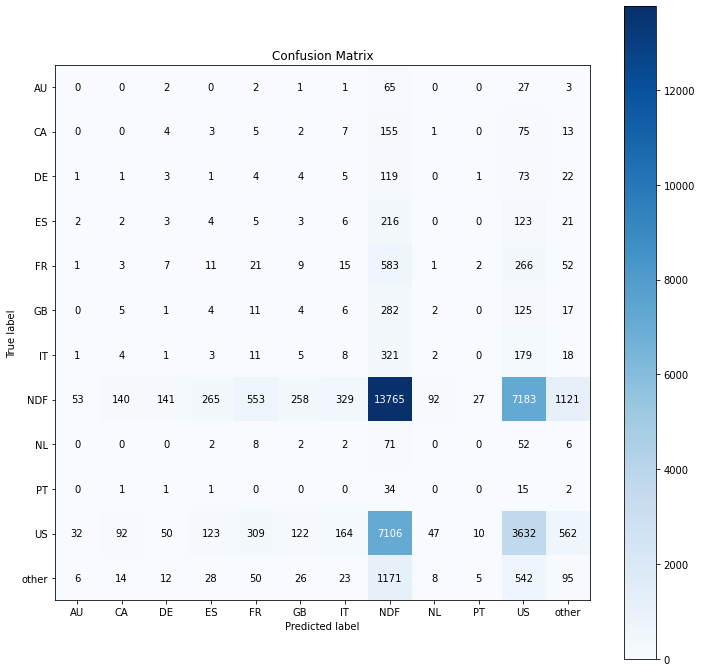

In [67]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 9.2. Neural Network Performance

### 9.2.1. Neural Network - Random Undersampling

In [68]:
# prediction
pred_under_nn = model_under.predict(x_test_under)

# invert prediction
yhat_under_nn = ohe_under.inverse_transform(pred_under_nn)

# test dataset prepare with real results
y_test_under_nn = y_test_under.to_numpy()
yhat_under_nn = yhat_under_nn.reshape(1, -1)[0]

In [69]:
# check balanced results
pd.DataFrame(yhat_under_nn).value_counts(normalize=True)

PT     0.660156
DE     0.214844
NDF    0.099609
NL     0.013672
GB     0.007812
AU     0.001953
US     0.001953
dtype: float64

Accuracy: 0.185546875
Balanced Accuracy: 0.17408509836531239
Kappa Score: 0.10483505794354908
              precision    recall  f1-score   support

          AU       1.00      0.02      0.05        43
          CA       0.00      0.00      0.00        43
          DE       0.13      0.31      0.18        45
          ES       0.00      0.00      0.00        46
          FR       0.00      0.00      0.00        35
          GB       0.00      0.00      0.00        50
          IT       0.00      0.00      0.00        55
         NDF       0.88      1.00      0.94        45
          NL       0.14      0.03      0.05        32
          PT       0.10      0.72      0.18        47
          US       0.00      0.00      0.00        38
       other       0.00      0.00      0.00        33

    accuracy                           0.19       512
   macro avg       0.19      0.17      0.12       512
weighted avg       0.19      0.19      0.12       512



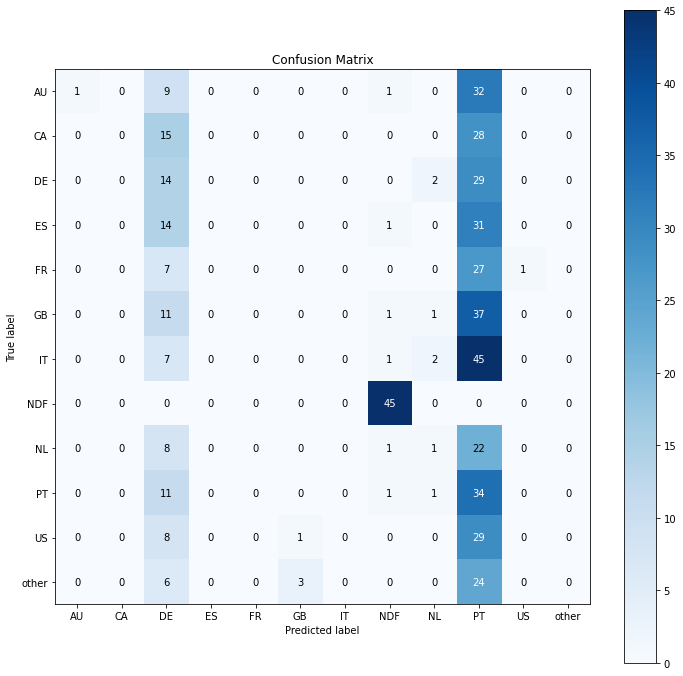

In [70]:
# Accuracy
acc_under_nn = m.accuracy_score( y_test_under_nn, yhat_under_nn )
print(f'Accuracy: {acc_under_nn}')

# Balanced Accuracy
balanced_acc_under_nn = m.balanced_accuracy_score(y_test_under_nn, yhat_under_nn)
print(f'Balanced Accuracy: {balanced_acc_under_nn}')

# Kappa Metrics
kappa_under_nn = m.cohen_kappa_score(y_test_under_nn, yhat_under_nn)
print(f'Kappa Score: {kappa_under_nn}')

# Classification report
print(m.classification_report(y_test_under_nn, yhat_under_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_under_nn, yhat_under_nn, normalize=False, figsize=(12,12));

### 9.2.2. Neural Network - Random Oversampling

In [71]:
# prediction
pred_over_nn = model_over.predict(x_test_over)

# invert prediction
yhat_over_nn = ohe_over.inverse_transform(pred_over_nn)

# test dataset prepare with real results
y_test_over_nn = y_test_over.to_numpy()
yhat_over_nn = yhat_over_nn.reshape(1, -1)[0]

In [72]:
# check balanced results
pd.DataFrame(yhat_over_nn).value_counts(normalize=True)

other    0.912862
NDF      0.083351
PT       0.003787
dtype: float64

Accuracy: 0.16781431711320702
Balanced Accuracy: 0.1680193119828757
Kappa Score: 0.09255327331978158
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00     23979
          CA       0.00      0.00      0.00     24024
          DE       0.00      0.00      0.00     24042
          ES       0.00      0.00      0.00     23971
          FR       0.00      0.00      0.00     24083
          GB       0.00      0.00      0.00     23936
          IT       0.00      0.00      0.00     23859
         NDF       1.00      1.00      1.00     24038
          NL       0.00      0.00      0.00     24168
          PT       0.51      0.02      0.04     23785
          US       0.00      0.00      0.00     23828
       other       0.09      1.00      0.17     23831

    accuracy                           0.17    287544
   macro avg       0.13      0.17      0.10    287544
weighted avg       0.13      0.17      0.10    287544



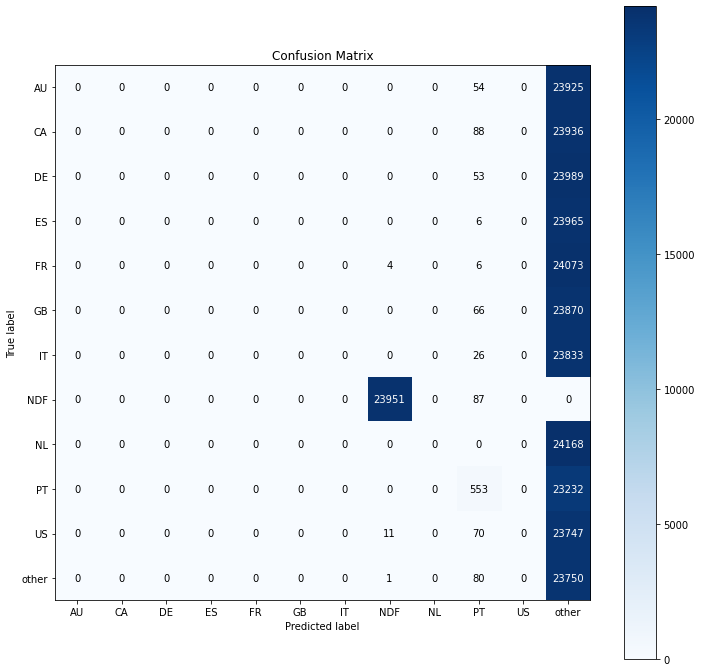

In [73]:
# Accuracy
acc_over_nn = m.accuracy_score( y_test_over_nn, yhat_over_nn )
print(f'Accuracy: {acc_over_nn}')

# Balanced Accuracy
balanced_acc_over_nn = m.balanced_accuracy_score(y_test_over_nn, yhat_over_nn)
print(f'Balanced Accuracy: {balanced_acc_over_nn}')

# Kappa Metrics
kappa_over_nn = m.cohen_kappa_score(y_test_over_nn, yhat_over_nn)
print(f'Kappa Score: {kappa_over_nn}')

# Classification report
print(m.classification_report(y_test_over_nn, yhat_over_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_over_nn, yhat_over_nn, normalize=False, figsize=(12,12));

### 9.2.3. Neural Network - SMOTE + TOMEKLINK

In [74]:
# prediction
pred_comb_nn = model_comb.predict(x_test_comb)

# invert prediction
yhat_comb_nn = ohe_comb.inverse_transform(pred_comb_nn)

# test dataset prepare with real results
y_test_comb_nn = y_test_comb.to_numpy()
yhat_comb_nn = yhat_comb_nn.reshape(1, -1)[0]

In [75]:
# check balanced results
pd.DataFrame(yhat_comb_nn).value_counts(normalize=True)

AU     0.916794
NDF    0.083199
DE     0.000003
IT     0.000003
dtype: float64

Accuracy: 0.1666005691345398
Balanced Accuracy: 0.16665624218163622
Kappa Score: 0.09076247702806095
              precision    recall  f1-score   support

          AU       0.09      1.00      0.17     23982
          CA       0.00      0.00      0.00     24029
          DE       0.00      0.00      0.00     23884
          ES       0.00      0.00      0.00     24022
          FR       0.00      0.00      0.00     23859
          GB       0.00      0.00      0.00     24079
          IT       0.00      0.00      0.00     23973
         NDF       1.00      1.00      1.00     23911
          NL       0.00      0.00      0.00     24285
          PT       0.00      0.00      0.00     23794
          US       0.00      0.00      0.00     23738
       other       0.00      0.00      0.00     23898

    accuracy                           0.17    287454
   macro avg       0.09      0.17      0.10    287454
weighted avg       0.09      0.17      0.10    287454



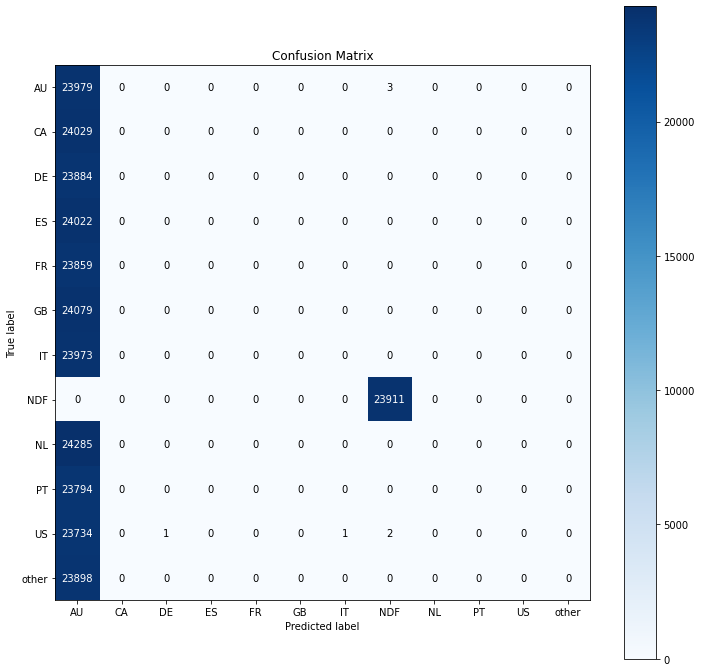

In [76]:
# Accuracy
acc_comb_nn = m.accuracy_score( y_test_comb_nn, yhat_comb_nn )
print(f'Accuracy: {acc_comb_nn}')

# Balanced Accuracy
balanced_acc_comb_nn = m.balanced_accuracy_score(y_test_comb_nn, yhat_comb_nn)
print(f'Balanced Accuracy: {balanced_acc_comb_nn}')

# Kappa Metrics
kappa_comb_nn = m.cohen_kappa_score(y_test_comb_nn, yhat_comb_nn)
print(f'Kappa Score: {kappa_comb_nn}')

# Classification report
print(m.classification_report(y_test_comb_nn, yhat_comb_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_comb_nn, yhat_comb_nn, normalize=False, figsize=(12,12));

## 9.3. Neural Network Performance - Cross-Validation

In [77]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

# balanced_acc_list = []

# kappa_list = []

# i = 1

# for train_index, val_index in kfold.split( x_train, y_train ):
#     print(f'Fold Number:{i}/{num_folds}')
    
#     # split data into training and test set
#     x_train_cv = x_train.iloc[train_index]
#     y_train_cv = y_train.iloc[train_index]
    
#     x_validation_cv = x_train.iloc[val_index]
#     y_validation_cv = y_train.iloc[val_index]
    
#     # encoding response variable
#     ohe = pp.OneHotEncoder()

#     y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add( l.Dense(128, input_dim=x_train_cv.shape[1], activation='relu') )
#     model.add( l.Dense(12, activation='softmax') )

#     # model compile
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # train model
#     model.fit(x_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_cv_nn = model.predict(x_validation_cv)

#     # invert prediction
#     yhat_cv_nn = ohe.inverse_transform(pred_cv_nn)

#     # test dataset prepare with real results
#     y_test_cv_nn = y_validation_cv.to_numpy()
#     yhat_cv_nn = yhat_cv_nn.reshape(1, -1)[0]
    
#     # performance metrics 
#     # Balanced Accuracy
#     balanced_acc_nn = m.balanced_accuracy_score(y_test_cv_nn, yhat_cv_nn)
#     balanced_acc_list.append(balanced_acc_nn)

#     # Kappa Metrics
#     kappa_nn = m.cohen_kappa_score(y_test_cv_nn, yhat_cv_nn)
#     kappa_list.append(kappa_nn)
    
#     i += 1

In [78]:
# print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_list), 2)} +/- {np.round(np.std(balanced_acc_list),5)}')
# print(f'Avg Kappa Score: {np.round(np.mean(kappa_list), 2)} +/- {np.round(np.std(kappa_list), 4)}')

**Result**

The use of sampling methods to handle the imbalanced dataset did not yield positive results in the model's performance metrics.

The use of 3 mechanisms to obtain a balanced distribution of classes was considered, including Random Undersampling, Random Oversampling and a synthetic sampling with data generation (SMOTE + Tomek links).

The balanced datasets showed similar results to each other and little difference to the previous cycle, with only the Kappa Score much lower(0.70 to 0.09).

The only difference observed was in the distribution of classes in the prediction data, with a greater plurality, previously concentrated between the two marjority classes (NDF and US).

# 10.0. Deploy Model

No models will be deployed yet.